# Wordcloud Hit No Hit

In [29]:
#!pip install pyspark
#!pip install wordcloud
import numpy as np
import pandas as pd
from pyspark.sql import HiveContext
from pyspark import SparkContext
#hive_context = HiveContext(sc)
from os import path
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

import matplotlib.pyplot as plt
%matplotlib inline
import os
import sys
sys.path.append(os.getcwd())

import re
import nltk

nltk.download('stopwords')
nltk.download('wordnet')

from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.tokenize import RegexpTokenizer
from nltk.stem.wordnet import WordNetLemmatizer

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/jupyter/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/jupyter/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [30]:
os.getcwd()

'/home/jupyter/w266_project_topmusichits/notebooks'

In [31]:
song_charts = pd.read_csv("songs_charts-v2.csv")

In [32]:
song_charts.head()

,track_name,track_artist,lyrics,track_popularity,track_album_name,playlist_genre,playlist_subgenre,danceability,energy,key,...,instrumentalness,liveness,valence,tempo,duration_ms,language,song_year,trending_year,Weeks_On_Chart,Hit
0,#1 stunna,big tymers,"For sure, playboy Nigga can't out-stunt me whe...",0,I Got That Work (Explicit Version),rap,southern hip hop,0.552,0.839,2,...,0.00404,0.258,0.569,89.070,281960,en,2000,0,0,0
1,$20 fine,jimi hendrix,One more day feelin' this way Walkin' through ...,44,Both Sides of the Sky,rock,classic rock,0.569,0.887,0,...,0.43100,0.345,0.738,120.949,299080,en,2018,0,0,0
2,$ave dat money (feat. fetty wap & rich homie q...,lil dicky,"LD, AKA The Independent Variable Trap God, and...",69,Professional Rapper,rap,hip hop,0.858,0.697,2,...,0.00000,0.224,0.364,98.012,290836,en,2015,0,0,0
3,$dreams,max frost,Halos of diamonds dancing over your head My ey...,43,Intoxication,pop,indie poptimism,0.800,0.626,7,...,0.00416,0.103,0.792,106.974,214080,en,2015,0,0,0
4,'98 freestyle,big l,"Fuck all the glamours and glitz, I plan to get...",0,The Big Picture (Explicit Version),rap,gangster rap,0.608,0.598,1,...,0.00000,0.321,0.905,175.767,129853,en,2000,0,0,0


In [33]:
song_charts.shape

(11353, 24)

In [34]:
song_charts.dtypes

track_name            object
track_artist          object
lyrics                object
track_popularity       int64
track_album_name      object
playlist_genre        object
playlist_subgenre     object
danceability         float64
energy               float64
key                    int64
loudness             float64
mode                   int64
speechiness          float64
acousticness         float64
instrumentalness     float64
liveness             float64
valence              float64
tempo                float64
duration_ms            int64
language              object
song_year              int64
trending_year          int64
Weeks_On_Chart         int64
Hit                    int64
dtype: object

In [35]:
df_lyrics = song_charts[song_charts['lyrics'].notnull()]
df_lyrics.shape

(11353, 24)

In [36]:
df_lyrics.playlist_genre.value_counts()

pop      3290
r&b      2745
rap      2279
rock     2266
latin     773
Name: playlist_genre, dtype: int64

In [37]:
df_lyrics.song_year.value_counts()

2019    1897
2018     967
2017     895
2016     846
2015     687
2014     522
2013     355
2012     312
2008     304
2011     302
2005     271
2010     246
2006     215
2007     214
2009     211
2004     209
2003     192
2001     183
2020     171
1999     157
2000     155
1998     150
1996     148
2002     146
1994     141
1995     141
1997     137
1993     135
1991     130
1987     106
1992     100
1988     100
1990      88
1989      78
1985      75
1986      70
1984      64
1983      63
1982      60
1980      60
1981      50
Name: song_year, dtype: int64

In [38]:
conditions = [
    df_lyrics['song_year']<=1984,
    (df_lyrics['song_year']>=1985) & (df_lyrics['song_year']<=1989),
    (df_lyrics['song_year']>=1990) & (df_lyrics['song_year']<=1994),
    (df_lyrics['song_year']>=1995) & (df_lyrics['song_year']<=1999),
    (df_lyrics['song_year']>=2000) & (df_lyrics['song_year']<=2004),
    (df_lyrics['song_year']>=2005) & (df_lyrics['song_year']<=2009),
    (df_lyrics['song_year']>=2010) & (df_lyrics['song_year']<=2015),
    (df_lyrics['song_year']>=2016) & (df_lyrics['song_year']<=2020)
]
choices = [
    '1981 - 1984', 
    '1985 - 1989',          
    '1990 - 1994',            
    '1995 - 1999',
    '2000 - 2004',    
    '2005 - 2009',        
    '2010 - 2014',      
    '2015 - 2020',      
          ]
df_lyrics['year_condensed'] = np.select(conditions, choices)

df_lyrics.year_condensed.value_counts()

2015 - 2020    4776
2010 - 2014    2424
2005 - 2009    1215
2000 - 2004     885
1995 - 1999     733
1990 - 1994     594
1985 - 1989     429
1981 - 1984     297
Name: year_condensed, dtype: int64

In [39]:
# One dataset per genre
df_lyrics_pop = df_lyrics[df_lyrics['playlist_genre'] == 'pop']
print(df_lyrics_pop.shape)
df_lyrics_r_b = df_lyrics[df_lyrics['playlist_genre'] == 'r&b']
print(df_lyrics_r_b.shape)
df_lyrics_rock = df_lyrics[df_lyrics['playlist_genre'] == 'rock']
print(df_lyrics_rock.shape)
df_lyrics_rap = df_lyrics[df_lyrics['playlist_genre'] == 'rap']
print(df_lyrics_rap.shape)
df_lyrics_latin = df_lyrics[df_lyrics['playlist_genre'] == 'latin']
print(df_lyrics_latin.shape)

(3290, 25)
(2745, 25)
(2266, 25)
(2279, 25)
(773, 25)


In [40]:
df_lyrics.Hit.value_counts()

0    9447
1    1906
Name: Hit, dtype: int64

In [41]:
# One dataset per hit/no hit
df_lyrics_hit = df_lyrics[df_lyrics['Hit'] == 1]
print(df_lyrics_hit.shape)
df_lyrics_nohit = df_lyrics[df_lyrics['Hit'] == 0]
print(df_lyrics_nohit.shape)

(1906, 25)
(9447, 25)


In [42]:
#Random samples 10% stratified by year_condensed


df_lyrics_hit_s = df_lyrics_hit.groupby('year_condensed', group_keys=False).apply(lambda x: x.sample(frac=0.10))
df_lyrics_hit_s.shape
df_lyrics_nohit_s = df_lyrics_nohit.groupby('year_condensed', group_keys=False).apply(lambda x: x.sample(frac=0.01))
df_lyrics_nohit_s.shape

(94, 25)

### Pre-process the dataset to get a clened, normalized text corpus

In [63]:
dataset = df_lyrics_hit_s
datacol = 'lyrics'
from sklearn.feature_extraction.text import CountVectorizer
import re
import string
from nltk.stem.porter import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer
nltk.download('omw-1.4')
lem = WordNetLemmatizer()
ps = PorterStemmer()
stop_words = nltk.corpus.stopwords.words('english')



[nltk_data] Downloading package omw-1.4 to /home/jupyter/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [73]:
# Add stop words

newStopWords = [
    'nah',
    'na',
    'oh',
    'ooh',
    'oo',
    'uh',
    'la',
    'ah',
    'doo',
    'da'
]
stop_words.extend(newStopWords)

In [74]:
# Pre-process dataset to get a cleaned and normalised text corpus
corpus = []
dataset['word_count'] = dataset[datacol].apply(lambda x: len(str(x).split(" ")))
ds_count = len(dataset.word_count)
for i in range(0, ds_count):
    #Remove punctuation
    text = [re.sub('[^a-zA-Z]', ' ',i) for i in dataset[datacol]]

    #Convert to lowercase
    text = [word.lower() for word in text]

    #Remove tags
    text = [re.sub("&lt;/?.*?&gt;"," &lt;&gt; ",i) for i in text]

    #Remove special characters and digits
    text = [re.sub("(\\d|\\W)+"," ",i) for i in text]

    #Stemming
    ps = PorterStemmer()

    #Lemmatisation
    lem = WordNetLemmatizer()
    text = [lem.lemmatize(word) for word in text if not word in stop_words]
    text = " ".join(text)
    corpus.append(text)

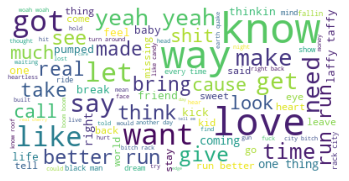

In [75]:
#Generate word cloud
from os import path
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import matplotlib.pyplot as plt
%matplotlib inline
wordcloud = WordCloud(
                        background_color = 'white',
                        stopwords = stop_words,
                        max_words = 100,
                        max_font_size = 50,
                        random_state = 42
                        ).generate(str(corpus))
print(wordcloud)
fig = plt.figure(1)
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

In [76]:
#Tokenize the text and build a vocabulary of known words
from sklearn.feature_extraction.text import CountVectorizer
import re 
cv = CountVectorizer(stop_words = stop_words, ngram_range = (1,3))
X = cv.fit_transform(corpus)

In [77]:
#Sample the returned vector encoding the length of the entire vocabulary
list(cv.vocabulary_.keys())[:10]

['gunter',
 'glieben',
 'glauchen',
 'globen',
 'hm',
 'tsk',
 'right',
 'yeah',
 'got',
 'something']

In [78]:
len(list(cv.vocabulary_.keys()))

49827

### Extract most frequently occuring keywords and n-grams

#### Unigrams

   Keyword  Frequency
0     yeah     193420
1     know     174610
2     like     167200
3     love     156180
4      way     131290
5      got     127110
6      let      92150
7    cause      87400
8      get      85120
9     baby      81510
10     one      78090
11   never      69160
12    time      68210
13  better      64030
14     run      62890
15      go      61750
16     say      61180
17    want      60420
18   right      58900
19   wanna      56620


[Text(0, 0, 'yeah'),
 Text(1, 0, 'know'),
 Text(2, 0, 'like'),
 Text(3, 0, 'love'),
 Text(4, 0, 'way'),
 Text(5, 0, 'got'),
 Text(6, 0, 'let'),
 Text(7, 0, 'cause'),
 Text(8, 0, 'get'),
 Text(9, 0, 'baby'),
 Text(10, 0, 'one'),
 Text(11, 0, 'never'),
 Text(12, 0, 'time'),
 Text(13, 0, 'better'),
 Text(14, 0, 'run'),
 Text(15, 0, 'go'),
 Text(16, 0, 'say'),
 Text(17, 0, 'want'),
 Text(18, 0, 'right'),
 Text(19, 0, 'wanna')]

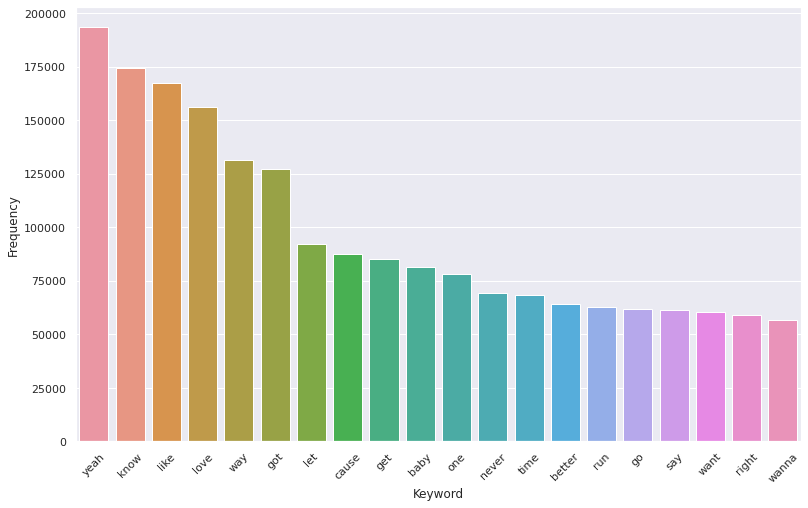

In [79]:
#View most frequently occuring keywords
def get_top_n_words(corpus, n=None):
    vec = CountVectorizer(stop_words = stop_words).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis = 0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in
                 vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key = lambda x: x[1],
                       reverse = True)
    return words_freq[:n]
    
#Convert most freq words to dataframe for plotting bar plot
top_words = get_top_n_words(corpus, n=20)
top_df = pd.DataFrame(top_words)
top_df.columns = ["Keyword", "Frequency"]
print(top_df)

#Barplot of most freq words
import seaborn as sns
sns.set(rc = {'figure.figsize':(13,8)})
g = sns.barplot(x="Keyword", y="Frequency", data = top_df)
g.set_xticklabels(g.get_xticklabels(), rotation = 45)

#### Bigrams

            Bi-gram  Frequency
0           way way      53960
1         yeah yeah      32870
2        better run      26600
3           run run      22800
4         love love      21280
5         one thing      17670
6         thing way      17100
7         know real      15390
8       laffy taffy      15200
9           way one      15200
10     thinkin much      13680
11      kids pumped      13300
12     pumped kicks      13300
13     kicks better      13300
14       run better      13300
15        woah woah      12920
16         let love      12160
17      bring bring      11970
18           let go      11780
19  cause heartless      11400


[Text(0, 0, 'way way'),
 Text(1, 0, 'yeah yeah'),
 Text(2, 0, 'better run'),
 Text(3, 0, 'run run'),
 Text(4, 0, 'love love'),
 Text(5, 0, 'one thing'),
 Text(6, 0, 'thing way'),
 Text(7, 0, 'know real'),
 Text(8, 0, 'laffy taffy'),
 Text(9, 0, 'way one'),
 Text(10, 0, 'thinkin much'),
 Text(11, 0, 'kids pumped'),
 Text(12, 0, 'pumped kicks'),
 Text(13, 0, 'kicks better'),
 Text(14, 0, 'run better'),
 Text(15, 0, 'woah woah'),
 Text(16, 0, 'let love'),
 Text(17, 0, 'bring bring'),
 Text(18, 0, 'let go'),
 Text(19, 0, 'cause heartless')]

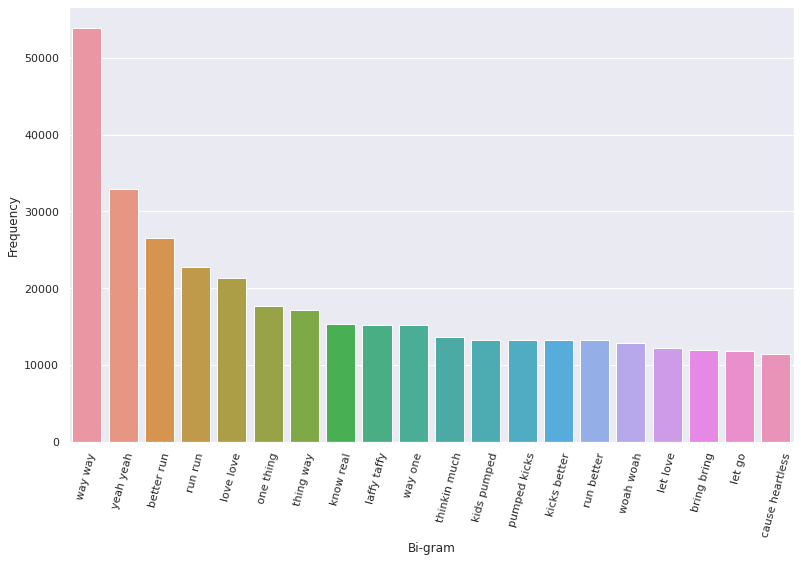

In [80]:
#View most frequently occuring bigrams
def get_top_n2_words(corpus, n=None):
    vec1 = CountVectorizer(stop_words = stop_words, ngram_range=(2,2)).fit(corpus)
    bag_of_words = vec1.transform(corpus)
    sum_words = bag_of_words.sum(axis = 0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in
                 vec1.vocabulary_.items()]
    words_freq = sorted(words_freq, key = lambda x: x[1],
                       reverse = True)
    return words_freq[:n]
    
#Convert most freq words to dataframe for plotting bar plot
top2_words = get_top_n2_words(corpus, n=20)
top2_df = pd.DataFrame(top2_words)
top2_df.columns = ["Bi-gram", "Frequency"]
print(top2_df)

#Barplot of most freq words
import seaborn as sns
sns.set(rc = {'figure.figsize':(13,8)})
h = sns.barplot(x="Bi-gram", y="Frequency", data = top2_df)
h.set_xticklabels(h.get_xticklabels(), rotation = 75)

#### Trigrams

                Tri-gram  Frequency
0            way way way      49970
1            run run run      21850
2          one thing way      17100
3         yeah yeah yeah      16720
4          way one thing      15200
5          thing way one      14250
6      kids pumped kicks      13300
7    pumped kicks better      13300
8       kicks better run      13300
9      better run better      13300
10        run better run      13300
11       rack city bitch      10070
12         roof let love       9500
13         know roof let       9310
14        shit shit shit       9120
15     bring bring bring       8550
16  thinkin much thinkin       8360
17     much thinkin much       8360
18      bring right back       8360
19       city bitch rack       7980


[Text(0, 0, 'way way way'),
 Text(1, 0, 'run run run'),
 Text(2, 0, 'one thing way'),
 Text(3, 0, 'yeah yeah yeah'),
 Text(4, 0, 'way one thing'),
 Text(5, 0, 'thing way one'),
 Text(6, 0, 'kids pumped kicks'),
 Text(7, 0, 'pumped kicks better'),
 Text(8, 0, 'kicks better run'),
 Text(9, 0, 'better run better'),
 Text(10, 0, 'run better run'),
 Text(11, 0, 'rack city bitch'),
 Text(12, 0, 'roof let love'),
 Text(13, 0, 'know roof let'),
 Text(14, 0, 'shit shit shit'),
 Text(15, 0, 'bring bring bring'),
 Text(16, 0, 'thinkin much thinkin'),
 Text(17, 0, 'much thinkin much'),
 Text(18, 0, 'bring right back'),
 Text(19, 0, 'city bitch rack')]

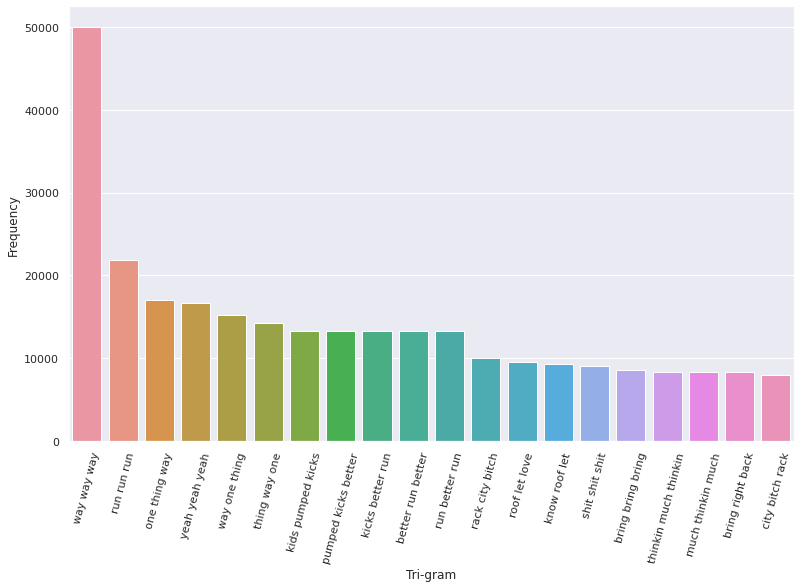

In [81]:
#View most frequently occuring trigrams
def get_top_n3_words(corpus, n=None):
    vec = CountVectorizer(stop_words = stop_words, ngram_range=(3,3)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis = 0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in
                 vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key = lambda x: x[1],
                       reverse = True)
    return words_freq[:n]
    
#Convert most freq trigrams to dataframe for plotting bar plot, save as CSV
top3_words = get_top_n3_words(corpus, n=20)
top3_df = pd.DataFrame(top3_words)
top3_df.columns = ["Tri-gram", "Frequency"]
print(top3_df)

#Barplot of most freq Tri-grams
import seaborn as sns
sns.set(rc = {'figure.figsize':(13,8)})
j = sns.barplot(x="Tri-gram", y="Frequency", data = top3_df)
j.set_xticklabels(j.get_xticklabels(), rotation = 75)